# FCN（Fully Convolutional Network）を実装し，CamVidデータセットにSegmentationを実行

In [10]:
!git clone https://github.com/alexgkendall/SegNet-Tutorial.git

fatal: destination path 'SegNet-Tutorial' already exists and is not an empty directory.


In [11]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
import numpy as np

class CamVidDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None, label_transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(img_dir))
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])

        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path)

        if self.transform:
            image = self.transform(image)

        if self.label_transform:
            label = self.label_transform(label)

        label = label.squeeze(0).long()

        return image, label

In [12]:
import numpy as np
from torch.utils.data import DataLoader

label_transform = T.Compose([
    T.Resize((480, 360), interpolation=T.InterpolationMode.NEAREST),
    T.PILToTensor()   # ★ 明示的に Tensor 化
])

image_transform = T.Compose([
    T.Resize((480, 360)),
    T.ToTensor()
])

train_dataset = CamVidDataset(
    "SegNet-Tutorial/CamVid/train",
    "SegNet-Tutorial/CamVid/trainannot",
    image_transform,
    label_transform
)

val_dataset = CamVidDataset(
    "SegNet-Tutorial/CamVid/val",
    "SegNet-Tutorial/CamVid/valannot",
    image_transform,
    label_transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)

# 可視化専用（順番をシャッフル）
val_loader_vis = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=True
)

In [13]:
labels = [y.max().item() for _, y in train_dataset]
num_classes = max(labels) + 1
print("num_classes:", num_classes)

num_classes: 12


In [14]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16

class FCN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        vgg = vgg16(pretrained=True).features

        self.pool3 = vgg[:17]   # pool3 まで
        self.pool4 = vgg[17:24] # pool4 まで
        self.pool5 = vgg[24:]   # pool5 以降

        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.score_pool5 = nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        input_size = x.shape[2:]

        x3 = self.pool3(x)          # 1/8
        x4 = self.pool4(x3)         # 1/16
        x5 = self.pool5(x4)         # 1/32
        s5 = self.score_pool5(x5)
        s5 = F.interpolate(s5, size=x4.shape[2:], mode="bilinear", align_corners=False)
        s4 = self.score_pool4(x4)
        s4 = s4 + s5                # FCN-16s
        s4 = F.interpolate(s4, size=x3.shape[2:], mode="bilinear", align_corners=False)
        s3 = self.score_pool3(x3)
        s3 = s3 + s4                # FCN-8s
        x = F.interpolate(s3, size=input_size, mode="bilinear", align_corners=False)

        x = F.interpolate(
            x, size=input_size,
            mode="bilinear", align_corners=False
        )
        return x


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FCN(num_classes=num_classes).to(device)

# --- class weight を train データから自動計算 ---
class_counts = torch.zeros(num_classes)

for _, y in train_dataset:
    y = y.view(-1)
    for cls in range(num_classes):
        class_counts[cls] += (y == cls).sum()

# 頻度の逆数を weight に（0割防止）
class_weights = 1.0 / (class_counts + 1e-6)

# 正規化（平均1に）
class_weights = class_weights / class_weights.mean()

class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    ignore_index=255
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    model.train()
    total_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.3f}")

Epoch 1, Loss: 193.301
Epoch 2, Loss: 143.586
Epoch 3, Loss: 120.530
Epoch 4, Loss: 114.796
Epoch 5, Loss: 95.737
Epoch 6, Loss: 91.912
Epoch 7, Loss: 82.855
Epoch 8, Loss: 71.632
Epoch 9, Loss: 75.606
Epoch 10, Loss: 66.273


In [16]:
def compute_iou(pred, target, num_classes, ignore_index=255):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    for cls in range(num_classes):
        if cls == ignore_index:
            continue

        pred_inds = pred == cls
        target_inds = target == cls

        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item() - intersection

        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)

    return np.nanmean(ious)

model.eval()

import random
torch.manual_seed(torch.seed())
np.random.seed()
random.seed()

total_inter = np.zeros(num_classes)
total_union = np.zeros(num_classes)

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)

        pred = model(x).argmax(1)
        for cls in range(num_classes):
            pred_inds = (pred == cls)
            target_inds = (y == cls)
            inter = (pred_inds & target_inds).sum().item()
            union = pred_inds.sum().item() + target_inds.sum().item() - inter
            total_inter[cls] += inter
            total_union[cls] += union

iou_per_class = total_inter / np.maximum(total_union, 1)
print(f"Mean IoU: {np.nanmean(iou_per_class):.4f}")

Mean IoU: 0.4424


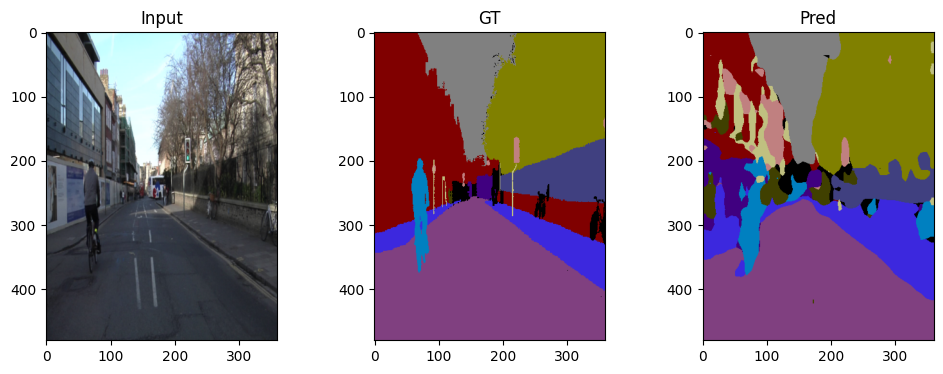

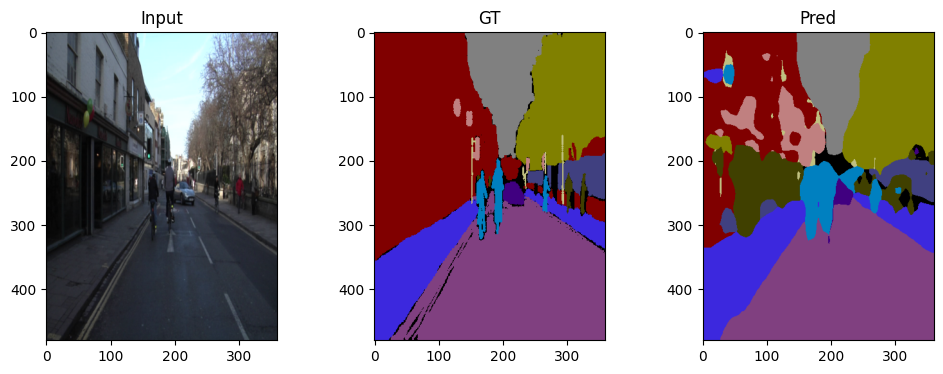

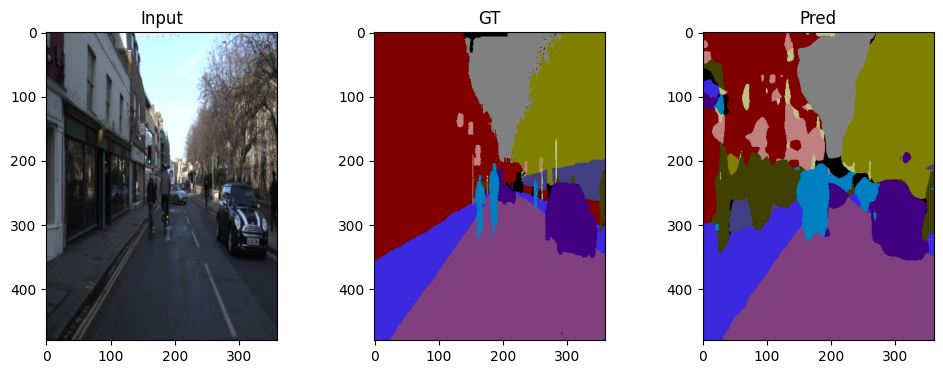

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def decode_segmap(segmentation, color_map):
    h, w = segmentation.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)

    rgb[segmentation == 255] = (0, 0, 0)

    for cls_id, color in color_map.items():
        rgb[segmentation == cls_id] = color

    return rgb

CAMVID_COLORS = {
    0: (128,128,128),  # Sky（空）
    1: (128,0,0),      # Building（建物）
    2: (192,192,128),  # Pole（ポール・標識柱）
    3: (128,64,128),   # Road（道路）
    4: (60,40,222),    # Pavement（歩道）
    5: (128,128,0),    # Tree（木・植生）
    6: (192,128,128),  # SignSymbol（標識・看板）
    7: (64,64,128),    # Fence（フェンス）
    8: (64,0,128),     # Car（車）
    9: (64,64,0),      # Pedestrian（歩行者）
    10: (0,128,192),   # Bicyclist（自転車）
    11: (0,0,0)        # Unlabelled / Void（未ラベル領域）
}

model.eval()

for i, (x, y) in enumerate(val_loader_vis):
    if i >= 3:  # 3枚だけ表示
        break

    x = x.to(device)
    with torch.no_grad():
        pred = model(x).argmax(1).cpu().numpy()[0]

    img = x.cpu().numpy()[0].transpose(1, 2, 0)
    gt = y.numpy()[0]

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Input")

    plt.subplot(1,3,2)
    plt.imshow(decode_segmap(gt, CAMVID_COLORS))
    plt.title("GT")

    plt.subplot(1,3,3)
    plt.imshow(decode_segmap(pred, CAMVID_COLORS))
    plt.title("Pred")

    plt.show()